In [1]:
#must be very first statement

import tensorflow as tf
tf.debugging.set_log_device_placement(True)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Num GPUs Available:  1
Default GPU Device: /device:GPU:0


In [2]:
#%config IPCompleter.greedy=True

In [3]:
#utils'

import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import Callback, LearningRateScheduler
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.datasets import mnist
import PIL


def getDigits(show=False):
    (x_train, t_train), (x_test, t_test) = mnist.load_data()

    #print(x_train.shape)

    if show:
        showImages(x_train, t_train,5)

    return x_train,t_train,x_test, t_test


#### CALLBACKS (https://github.com/davidADSP/GDL_code/blob/master/utils/callbacks.py)
class CustomCallback(Callback):

    def __init__(self, run_folder, print_every_n_batches, initial_epoch, vae):
        self.epoch = initial_epoch
        self.run_folder = run_folder
        self.print_every_n_batches = print_every_n_batches
        self.vae = vae

    def on_batch_end(self, batch, logs={}):
        if batch % self.print_every_n_batches == 0:
            z_new = np.random.normal(size=(1, self.vae.z_dim))
            reconst = self.vae.decoder.predict(np.array(z_new))[0].squeeze()

            filepath = os.path.join(self.run_folder, 'images',
                                    'img_' + str(self.epoch).zfill(3) + '_' + str(batch) + '.jpg')
            if len(reconst.shape) == 2:
                plt.imsave(filepath, reconst, cmap='gray_r')
            else:
                plt.imsave(filepath, reconst)

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch += 1

#### CALLBACKS (https://github.com/davidADSP/GDL_code/blob/master/utils/callbacks.py)
def step_decay_schedule(initial_lr, decay_factor=0.5, step_size=1):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''

    def schedule(epoch):
        new_lr = initial_lr * (decay_factor ** np.floor(epoch / step_size))

        return new_lr

    return LearningRateScheduler(schedule)

Using TensorFlow backend.


In [4]:
#data prep

from keras.datasets import cifar10
cifar10.load_data()

my_labels = [2]
all_label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
label_names = []
for label_index in my_labels:
    label_names.append(all_label_names[label_index])  

print("Defining new Labeling:")
print(dict(zip(range(len(my_labels)),label_names)))

#if my_labels = [5,6,8] then 5 returns 0, 6 returns 1, 8 returns 2, ...
def convert_label(label):
    return dict(zip(my_labels,range(len(my_labels))))[label]

def label_name(num):
    return label_names[num]

# The data, split between train and test sets:
(x_train_all, y_train_all), (x_test_all, y_test_all) = cifar10.load_data()
    
#temp lists
x_train = []
y_train_numerical = []

#filter training data for my_labels
for i in range(len(x_train_all)):
    if y_train_all[i] in my_labels:
        x_train.append(x_train_all[i])
        y_train_numerical.append(convert_label(y_train_all[i][0]))
    else:
        pass

x_train = np.array(x_train)
y_train_numerical = np.array(y_train_numerical)

print("Training Data:\n")
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'samples,', y_train_numerical.shape[0], 'labels')
print("\nClass  |  Counts:")
(unique, counts) = np.unique(y_train_numerical, return_counts=True)
for i, label in enumerate(unique):
    print(label_name(label),"\t", counts[i])


x_test = []
y_test_numerical = []

#filter test data
for i in range(len(x_test_all)):
    if y_test_all[i] in my_labels:
        x_test.append(x_test_all[i])
        y_test_numerical.append(convert_label(y_test_all[i][0]))
    else:
        pass

x_test = np.array(x_test)
y_test_numerical = np.array(y_test_numerical)

print("\n\nTesting Data:\n")
print('x_test shape:', x_test.shape)
print(x_test.shape[0], 'samples,', y_test_numerical.shape[0], 'labels')
print("\nClass  |  Counts:")
(unique, counts) = np.unique(y_test_numerical, return_counts=True)
for i, label in enumerate(unique):
    print(label_name(label),"\t", counts[i])
    
x_train=x_train.reshape(x_train.shape[0],32,32,3)
x_test=x_test.reshape(x_test.shape[0],32,32,3)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255


Defining new Labeling:
{0: 'bird'}
Training Data:

x_train shape: (5000, 32, 32, 3)
5000 samples, 5000 labels

Class  |  Counts:
bird 	 5000


Testing Data:

x_test shape: (1000, 32, 32, 3)
1000 samples, 1000 labels

Class  |  Counts:
bird 	 1000


In [5]:
#model class

from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model
from keras import callbacks

import numpy as np
import json
import os
import pickle


class VariationalAutoencoder():
    def __init__(self
                 , input_dim
                 , encoder_conv_filters
                 , encoder_conv_kernel_size
                 , encoder_conv_strides
                 , decoder_conv_t_filters
                 , decoder_conv_t_kernel_size
                 , decoder_conv_t_strides
                 , z_dim
                 , use_batch_norm=False
                 , use_dropout=False
                 ):

        self.name = 'variational_autoencoder'

        self.input_dim = input_dim
        self.encoder_conv_filters = encoder_conv_filters
        self.encoder_conv_kernel_size = encoder_conv_kernel_size
        self.encoder_conv_strides = encoder_conv_strides
        self.decoder_conv_t_filters = decoder_conv_t_filters
        self.decoder_conv_t_kernel_size = decoder_conv_t_kernel_size
        self.decoder_conv_t_strides = decoder_conv_t_strides
        self.z_dim = z_dim

        self.use_batch_norm = use_batch_norm
        self.use_dropout = use_dropout

        self.n_layers_encoder = len(encoder_conv_filters)
        self.n_layers_decoder = len(decoder_conv_t_filters)

        self._build()

    def _build(self):

        ### THE ENCODER
        encoder_input = Input(shape=self.input_dim, name='encoder_input')

        x = encoder_input

        for i in range(self.n_layers_encoder):
            conv_layer = Conv2D(
                filters=self.encoder_conv_filters[i]
                , kernel_size=self.encoder_conv_kernel_size[i]
                , strides=self.encoder_conv_strides[i]
                , padding='same'
                , name='encoder_conv_' + str(i)
            )

            x = conv_layer(x)

            if self.use_batch_norm:
                x = BatchNormalization()(x)

            x = LeakyReLU()(x)

            if self.use_dropout:
                x = Dropout(rate=0.25)(x)

        shape_before_flattening = K.int_shape(x)[1:]
#-----------------------------
        print("shape_bef_flat",shape_before_flattening)
        x = Flatten()(x)
        print("shape_aft_flat",x)
        self.mu = Dense(self.z_dim, name='mu')(x)
        self.log_var = Dense(self.z_dim, name='log_var')(x)

        self.encoder_mu_log_var = Model(encoder_input, (self.mu, self.log_var))

        def sampling(args):
            mu, log_var = args
            epsilon = K.random_normal(shape=K.shape(mu), mean=0., stddev=1)
            return mu + K.exp(log_var / 2) * epsilon #try without /2

        encoder_output = Lambda(sampling, name='encoder_output')([self.mu, self.log_var])
        print("encoder_output: ",encoder_output)
        self.encoder = Model(encoder_input, encoder_output)

        ### THE DECODER

        decoder_input = Input(shape=(self.z_dim,), name='decoder_input')
        print("dec_input",decoder_input)
        x = Dense(np.prod(shape_before_flattening))(decoder_input)
        x = Reshape(shape_before_flattening)(x)

        for i in range(self.n_layers_decoder):
            conv_t_layer = Conv2DTranspose(
                filters=self.decoder_conv_t_filters[i]
                , kernel_size=self.decoder_conv_t_kernel_size[i]
                , strides=self.decoder_conv_t_strides[i]
                , padding='same'
                , name='decoder_conv_t_' + str(i)
            )

            x = conv_t_layer(x)

            if i < self.n_layers_decoder - 1:
                if self.use_batch_norm:
                    x = BatchNormalization()(x)
                x = LeakyReLU()(x)
                if self.use_dropout:
                    x = Dropout(rate=0.25)(x)
            else:
                x = Activation('sigmoid')(x)

        decoder_output = x
        print("dec_inputtii",decoder_input)
        self.decoder = Model(decoder_input, decoder_output)

        ### THE FULL VAE
        model_input = encoder_input
        model_output = self.decoder(encoder_output)
        
        self.model = Model(model_input, model_output)

    def compile(self, learning_rate, r_loss_factor):
        self.learning_rate = learning_rate

        ### COMPILATION
        def vae_r_loss(y_true, y_pred):
            r_loss = K.mean(K.square(y_true - y_pred), axis=[1, 2, 3])
            return r_loss * r_loss_factor

        def vae_kl_loss(y_true, y_pred):
            kl_loss = -0.5 * K.sum(1 + self.log_var - K.square(self.mu) - K.exp(self.log_var), axis=1)
            return kl_loss

        def vae_loss(y_true, y_pred):
            #return 0.99*vae_r_loss(y_true,y_pred)+0.01*vae_kl_loss(y_true,y_pred)
            r_loss = vae_r_loss(y_true, y_pred)
            kl_loss = vae_kl_loss(y_true, y_pred)
            return r_loss + kl_loss

        optimizer = Adam(lr=learning_rate)
        self.model.compile(optimizer=optimizer, loss=vae_loss, metrics=[vae_r_loss, vae_kl_loss])

    def save(self, folder="run"):
        if not os.path.exists(folder):
            os.makedirs(folder)
            os.makedirs(os.path.join(folder, 'viz'))
            os.makedirs(os.path.join(folder, 'weights'))
            os.makedirs(os.path.join(folder, 'images'))

        with open(os.path.join(folder, 'params.pkl'), 'wb') as f:
            pickle.dump([
                self.input_dim
                , self.encoder_conv_filters
                , self.encoder_conv_kernel_size
                , self.encoder_conv_strides
                , self.decoder_conv_t_filters
                , self.decoder_conv_t_kernel_size
                , self.decoder_conv_t_strides
                , self.z_dim
                , self.use_batch_norm
                , self.use_dropout
            ], f)

        self.plot_model(folder)

    def load_weights(self, filepath):
        self.model.load_weights(filepath)

    def train(self, x_train, batch_size, epochs, run_folder, print_every_n_batches=100, initial_epoch=0, lr_decay=1):

        custom_callback = CustomCallback(run_folder, print_every_n_batches, initial_epoch, self)
        lr_sched = step_decay_schedule(initial_lr=self.learning_rate, decay_factor=lr_decay, step_size=1)

        checkpoint_filepath = os.path.join(run_folder, "weights/weights.h5")
        
        model_checkpoint_callback = callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=True,
            monitor='val_acc',
            mode='max')

        
        #checkpoint1 = ModelCheckpoint(checkpoint_filepath, save_weights_only=True, verbose=1)
        #checkpoint2 = ModelCheckpoint(os.path.join(run_folder, 'weights/weights.h5'), save_weights_only=True, verbose=1)

        callbacks_list = [custom_callback, lr_sched, model_checkpoint_callback]

        self.model.fit(
            x_train
            , x_train
            , batch_size=batch_size
            , shuffle=True
            , epochs=epochs
            , initial_epoch=initial_epoch
            , callbacks=callbacks_list
        )

    def plot_model(self, run_folder):
        plot_model(self.model, to_file=os.path.join(run_folder, 'viz/model.png'), show_shapes=True,
                   show_layer_names=True)
        plot_model(self.encoder, to_file=os.path.join(run_folder, 'viz/encoder.png'), show_shapes=True,
                   show_layer_names=True)
        plot_model(self.decoder, to_file=os.path.join(run_folder, 'viz/decoder.png'), show_shapes=True,
                   show_layer_names=True)



In [7]:
#training
SECTION = 'vae'
RUN_ID = '0002'
DATA_NAME = 'digits'
RUN_FOLDER = 'run'

cwd = os.getcwd()
print(cwd)
if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' #'load' #

vae = VariationalAutoencoder(
    input_dim = (32,32,3)
    , encoder_conv_filters = [128,128,128,512]
    , encoder_conv_kernel_size = [2,2,3,4]
    , encoder_conv_strides = [1,1,2,2]
    , decoder_conv_t_filters = [512,128,128,3]
    , decoder_conv_t_kernel_size = [4,3,2,2]
    , decoder_conv_t_strides = [2,2,1,1]
    , z_dim = 128
)
vae.save(RUN_FOLDER)

vae.load_weights("run/weights/weights.h5")

vae.encoder.summary()

LEARNING_RATE = 0.00001
R_LOSS_FACTOR = 1000
vae.compile(LEARNING_RATE, R_LOSS_FACTOR)

BATCH_SIZE = 32
EPOCHS = 1000
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0

vae.train(
    x_train
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , initial_epoch = INITIAL_EPOCH
)
vae.save()




S:\Hub\ML_SS_2020
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
shape_bef_flat (8, 8, 512)
shape_aft_flat Tensor("flatten_2/Reshape:0", shape=(None, None), dtype=float32)
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
encoder_output:  Tensor("encoder_output_1/add:0", shape=(None, 128), dtype=float32)
dec_input Tensor("decoder_input_1:0", shape=(None, 128), dtype=float32)
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/t

C:\Users\Admin\Anaconda3\envs\ml20\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.445507). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


5000/5000 [==============================] - 16s 3ms/step - loss: 24.3914 - vae_r_loss: 15.7822 - vae_kl_loss: 8.6092
Epoch 2/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 24.3146 - vae_r_loss: 15.6679 - vae_kl_loss: 8.6467
Epoch 3/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 24.2715 - vae_r_loss: 15.5874 - vae_kl_loss: 8.6840
Epoch 4/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 24.3266 - vae_r_loss: 15.6191 - vae_kl_loss: 8.7075
Epoch 5/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 24.3832 - vae_r_loss: 15.6525 - vae_kl_loss: 8.7306
Epoch 6/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 24.3194 - vae_r_loss: 15.5935 - vae_kl_loss: 8.7258
Epoch 7/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 24.2622 - vae_r_loss: 15.5750 - vae_kl_loss: 8.6872
Epoch 8/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 24.2886 - vae_r_loss: 15

5000/5000 [==============================] - 8s 2ms/step - loss: 24.1231 - vae_r_loss: 15.4135 - vae_kl_loss: 8.7096
Epoch 64/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 24.1430 - vae_r_loss: 15.4404 - vae_kl_loss: 8.7026
Epoch 65/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 24.1800 - vae_r_loss: 15.4230 - vae_kl_loss: 8.7569
Epoch 66/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 24.1159 - vae_r_loss: 15.3774 - vae_kl_loss: 8.7385
Epoch 67/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 24.1471 - vae_r_loss: 15.4183 - vae_kl_loss: 8.7288
Epoch 68/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 24.0538 - vae_r_loss: 15.3966 - vae_kl_loss: 8.6572
Epoch 69/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 24.1771 - vae_r_loss: 15.4239 - vae_kl_loss: 8.7532
Epoch 70/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 24.1459 - vae_r_lo

5000/5000 [==============================] - 8s 2ms/step - loss: 24.0356 - vae_r_loss: 15.2588 - vae_kl_loss: 8.7768
Epoch 125/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.9927 - vae_r_loss: 15.2851 - vae_kl_loss: 8.7076
Epoch 126/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.9926 - vae_r_loss: 15.2936 - vae_kl_loss: 8.6990
Epoch 127/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.9634 - vae_r_loss: 15.2322 - vae_kl_loss: 8.7312
Epoch 128/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 24.0670 - vae_r_loss: 15.3084 - vae_kl_loss: 8.7586
Epoch 129/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 24.0540 - vae_r_loss: 15.2946 - vae_kl_loss: 8.7595
Epoch 130/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.9889 - vae_r_loss: 15.2861 - vae_kl_loss: 8.7027
Epoch 131/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 24.0250 - v

5000/5000 [==============================] - 8s 2ms/step - loss: 23.9728 - vae_r_loss: 15.1904 - vae_kl_loss: 8.7825
Epoch 187/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.9632 - vae_r_loss: 15.1687 - vae_kl_loss: 8.7945
Epoch 188/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 24.0027 - vae_r_loss: 15.2118 - vae_kl_loss: 8.7909
Epoch 189/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.9281 - vae_r_loss: 15.1606 - vae_kl_loss: 8.7676
Epoch 190/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.9239 - vae_r_loss: 15.1508 - vae_kl_loss: 8.7730
Epoch 191/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.9847 - vae_r_loss: 15.2453 - vae_kl_loss: 8.7394
Epoch 192/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.9498 - vae_r_loss: 15.1359 - vae_kl_loss: 8.8138
Epoch 193/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.9061 - v

5000/5000 [==============================] - 8s 2ms/step - loss: 23.9136 - vae_r_loss: 15.1182 - vae_kl_loss: 8.7954
Epoch 248/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.9269 - vae_r_loss: 15.0806 - vae_kl_loss: 8.8463
Epoch 249/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.8548 - vae_r_loss: 15.0704 - vae_kl_loss: 8.7844
Epoch 250/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.8889 - vae_r_loss: 15.0928 - vae_kl_loss: 8.7961
Epoch 251/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.8927 - vae_r_loss: 15.1069 - vae_kl_loss: 8.7859
Epoch 252/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.9059 - vae_r_loss: 15.0902 - vae_kl_loss: 8.8157
Epoch 253/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.9158 - vae_r_loss: 15.0750 - vae_kl_loss: 8.8408
Epoch 254/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.9552 - v

5000/5000 [==============================] - 8s 2ms/step - loss: 23.8414 - vae_r_loss: 15.0072 - vae_kl_loss: 8.8342
Epoch 310/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.7970 - vae_r_loss: 14.9937 - vae_kl_loss: 8.8033
Epoch 311/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.8887 - vae_r_loss: 14.9587 - vae_kl_loss: 8.9300
Epoch 312/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.8934 - vae_r_loss: 14.9937 - vae_kl_loss: 8.8997
Epoch 313/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.7759 - vae_r_loss: 14.9745 - vae_kl_loss: 8.8014
Epoch 314/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.8600 - vae_r_loss: 15.0101 - vae_kl_loss: 8.8499
Epoch 315/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.8036 - vae_r_loss: 14.9888 - vae_kl_loss: 8.8148
Epoch 316/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.8163 - v

5000/5000 [==============================] - 8s 2ms/step - loss: 23.8074 - vae_r_loss: 14.9316 - vae_kl_loss: 8.8758
Epoch 371/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.8008 - vae_r_loss: 14.9554 - vae_kl_loss: 8.8454
Epoch 372/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.8249 - vae_r_loss: 14.8767 - vae_kl_loss: 8.9483
Epoch 373/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.7521 - vae_r_loss: 14.9129 - vae_kl_loss: 8.8392
Epoch 374/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.7938 - vae_r_loss: 14.9491 - vae_kl_loss: 8.8447
Epoch 375/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.7688 - vae_r_loss: 14.8808 - vae_kl_loss: 8.8880
Epoch 376/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.8128 - vae_r_loss: 14.9173 - vae_kl_loss: 8.8955
Epoch 377/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.7663 - v

5000/5000 [==============================] - 8s 2ms/step - loss: 23.6983 - vae_r_loss: 14.8609 - vae_kl_loss: 8.8374
Epoch 432/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.7597 - vae_r_loss: 14.8474 - vae_kl_loss: 8.9123
Epoch 433/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.7780 - vae_r_loss: 14.8318 - vae_kl_loss: 8.9462
Epoch 434/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.7561 - vae_r_loss: 14.8396 - vae_kl_loss: 8.9165
Epoch 435/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.7744 - vae_r_loss: 14.8600 - vae_kl_loss: 8.9144
Epoch 436/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.6801 - vae_r_loss: 14.8335 - vae_kl_loss: 8.8466
Epoch 437/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.7651 - vae_r_loss: 14.8431 - vae_kl_loss: 8.9220
Epoch 438/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.7669 - v

5000/5000 [==============================] - 8s 2ms/step - loss: 23.7059 - vae_r_loss: 14.7723 - vae_kl_loss: 8.9336
Epoch 493/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.7058 - vae_r_loss: 14.7307 - vae_kl_loss: 8.9751
Epoch 494/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.6578 - vae_r_loss: 14.7455 - vae_kl_loss: 8.9123
Epoch 495/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.6917 - vae_r_loss: 14.7457 - vae_kl_loss: 8.9460
Epoch 496/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.6937 - vae_r_loss: 14.7626 - vae_kl_loss: 8.9311
Epoch 497/1000
5000/5000 [==============================] - ETA: 0s - loss: 23.7012 - vae_r_loss: 14.7933 - vae_kl_loss: 8.90 - 8s 2ms/step - loss: 23.7073 - vae_r_loss: 14.7973 - vae_kl_loss: 8.9099
Epoch 498/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.6269 - vae_r_loss: 14.7426 - vae_kl_loss: 8.8843
Epoch 499/1000
5000/500

5000/5000 [==============================] - 8s 2ms/step - loss: 23.6785 - vae_r_loss: 14.7087 - vae_kl_loss: 8.9698
Epoch 554/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.6284 - vae_r_loss: 14.6651 - vae_kl_loss: 8.9633
Epoch 555/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.6089 - vae_r_loss: 14.6886 - vae_kl_loss: 8.9204
Epoch 556/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.6799 - vae_r_loss: 14.7206 - vae_kl_loss: 8.9593
Epoch 557/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.6560 - vae_r_loss: 14.6885 - vae_kl_loss: 8.9675
Epoch 558/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.6291 - vae_r_loss: 14.6655 - vae_kl_loss: 8.9636
Epoch 559/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.6013 - vae_r_loss: 14.6282 - vae_kl_loss: 8.9731
Epoch 560/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.5905 - v

5000/5000 [==============================] - 8s 2ms/step - loss: 23.5451 - vae_r_loss: 14.5795 - vae_kl_loss: 8.9656
Epoch 616/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.5599 - vae_r_loss: 14.6073 - vae_kl_loss: 8.9525
Epoch 617/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.5609 - vae_r_loss: 14.5864 - vae_kl_loss: 8.9745
Epoch 618/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.5893 - vae_r_loss: 14.6085 - vae_kl_loss: 8.9808
Epoch 619/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.5759 - vae_r_loss: 14.6133 - vae_kl_loss: 8.9626
Epoch 620/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.5857 - vae_r_loss: 14.5998 - vae_kl_loss: 8.9859
Epoch 621/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.4707 - vae_r_loss: 14.5463 - vae_kl_loss: 8.9244
Epoch 622/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.6178 - v

5000/5000 [==============================] - 8s 2ms/step - loss: 23.5201 - vae_r_loss: 14.5690 - vae_kl_loss: 8.9511
Epoch 677/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.5459 - vae_r_loss: 14.5337 - vae_kl_loss: 9.0123
Epoch 678/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.5324 - vae_r_loss: 14.5165 - vae_kl_loss: 9.0158
Epoch 679/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.4740 - vae_r_loss: 14.5237 - vae_kl_loss: 8.9503
Epoch 680/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.5473 - vae_r_loss: 14.5345 - vae_kl_loss: 9.0128
Epoch 681/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.5220 - vae_r_loss: 14.4991 - vae_kl_loss: 9.0229
Epoch 682/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.4983 - vae_r_loss: 14.4912 - vae_kl_loss: 9.0071
Epoch 683/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.4916 - v

5000/5000 [==============================] - 8s 2ms/step - loss: 23.5142 - vae_r_loss: 14.4777 - vae_kl_loss: 9.0366
Epoch 738/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.5032 - vae_r_loss: 14.4791 - vae_kl_loss: 9.0241
Epoch 739/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.4754 - vae_r_loss: 14.4478 - vae_kl_loss: 9.0276
Epoch 740/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.4447 - vae_r_loss: 14.4324 - vae_kl_loss: 9.0123
Epoch 741/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.5220 - vae_r_loss: 14.4635 - vae_kl_loss: 9.0586
Epoch 742/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.4690 - vae_r_loss: 14.4349 - vae_kl_loss: 9.0341
Epoch 743/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.4865 - vae_r_loss: 14.4701 - vae_kl_loss: 9.0164
Epoch 744/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.4793 - v

5000/5000 [==============================] - 8s 2ms/step - loss: 23.4716 - vae_r_loss: 14.4212 - vae_kl_loss: 9.0504
Epoch 799/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.4320 - vae_r_loss: 14.3883 - vae_kl_loss: 9.0437
Epoch 800/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.4574 - vae_r_loss: 14.4070 - vae_kl_loss: 9.0504
Epoch 801/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.4101 - vae_r_loss: 14.3845 - vae_kl_loss: 9.0256
Epoch 802/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.4422 - vae_r_loss: 14.3965 - vae_kl_loss: 9.0458
Epoch 803/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.4179 - vae_r_loss: 14.3384 - vae_kl_loss: 9.0796
Epoch 804/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.4121 - vae_r_loss: 14.3852 - vae_kl_loss: 9.0269
Epoch 805/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.4859 - v

5000/5000 [==============================] - 8s 2ms/step - loss: 23.4521 - vae_r_loss: 14.3143 - vae_kl_loss: 9.1378
Epoch 861/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.3705 - vae_r_loss: 14.3143 - vae_kl_loss: 9.0561
Epoch 862/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.3919 - vae_r_loss: 14.3374 - vae_kl_loss: 9.0545
Epoch 863/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.4241 - vae_r_loss: 14.3130 - vae_kl_loss: 9.1112
Epoch 864/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.3729 - vae_r_loss: 14.3235 - vae_kl_loss: 9.0494
Epoch 865/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.3554 - vae_r_loss: 14.2607 - vae_kl_loss: 9.0947
Epoch 866/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.3930 - vae_r_loss: 14.3061 - vae_kl_loss: 9.0869
Epoch 867/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.4060 - v

5000/5000 [==============================] - 8s 2ms/step - loss: 23.3491 - vae_r_loss: 14.2647 - vae_kl_loss: 9.0844
Epoch 922/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.3849 - vae_r_loss: 14.2458 - vae_kl_loss: 9.1392
Epoch 923/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.3252 - vae_r_loss: 14.2481 - vae_kl_loss: 9.0771
Epoch 924/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.3045 - vae_r_loss: 14.2290 - vae_kl_loss: 9.0754
Epoch 925/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.4024 - vae_r_loss: 14.2503 - vae_kl_loss: 9.1520
Epoch 926/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.2844 - vae_r_loss: 14.2210 - vae_kl_loss: 9.0634
Epoch 927/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.4145 - vae_r_loss: 14.2688 - vae_kl_loss: 9.1457
Epoch 928/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.3493 - v

5000/5000 [==============================] - 8s 2ms/step - loss: 23.3100 - vae_r_loss: 14.1665 - vae_kl_loss: 9.1435
Epoch 984/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.3177 - vae_r_loss: 14.2152 - vae_kl_loss: 9.1025
Epoch 985/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.2965 - vae_r_loss: 14.1802 - vae_kl_loss: 9.1163
Epoch 986/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.2424 - vae_r_loss: 14.1649 - vae_kl_loss: 9.0775
Epoch 987/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.2986 - vae_r_loss: 14.1725 - vae_kl_loss: 9.1261
Epoch 988/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.3135 - vae_r_loss: 14.1781 - vae_kl_loss: 9.1355
Epoch 989/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.3468 - vae_r_loss: 14.2056 - vae_kl_loss: 9.1412
Epoch 990/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.3551 - v

In [8]:
LEARNING_RATE = 0.000005
R_LOSS_FACTOR = 1000
vae.compile(LEARNING_RATE, R_LOSS_FACTOR)

BATCH_SIZE = 32
EPOCHS = 1000
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0

vae.train(
    x_train
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , initial_epoch = INITIAL_EPOCH
)
vae.save()

Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 1/1000
Executing op __inference_keras_scratch_graph_1015523 in device /job:localhost/replica:0/task:0/device:GPU:0
5000/5000 [==============================] - 14s 3ms/step - loss: 23.2451 - vae_r_loss: 14.1176 - vae_kl_loss: 9.1275
Epoch 2/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.2326 - vae_r_loss: 14.0859 - vae_kl_loss: 9.1467
Epoch 3/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.2259 - vae_r_loss: 14.1161 - vae_kl_loss: 9.1098
Epoch 4/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.2300 - vae_r_loss: 14.0986 - vae_kl_loss: 9.1313
Epoch 5/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.2967 - vae_r_loss: 14.1275 - vae_kl_loss: 9.1692
Epoch 6/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.2749 - vae_r_loss: 14.1236 - vae_kl_loss: 9.1513
Epoch 7/1000
5000/5000 [=

5000/5000 [==============================] - 8s 2ms/step - loss: 23.2360 - vae_r_loss: 14.0839 - vae_kl_loss: 9.1521
Epoch 62/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.1770 - vae_r_loss: 14.0143 - vae_kl_loss: 9.1627
Epoch 63/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.1640 - vae_r_loss: 14.0236 - vae_kl_loss: 9.1404: 0s - loss: 23.1566 - vae_r_loss: 14.
Epoch 64/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.1752 - vae_r_loss: 14.0448 - vae_kl_loss: 9.1304
Epoch 65/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.2262 - vae_r_loss: 14.0684 - vae_kl_loss: 9.1578
Epoch 66/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.1676 - vae_r_loss: 14.0263 - vae_kl_loss: 9.1413
Epoch 67/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.1280 - vae_r_loss: 14.0351 - vae_kl_loss: 9.0930
Epoch 68/1000
5000/5000 [==============================] - 

5000/5000 [==============================] - 8s 2ms/step - loss: 23.1510 - vae_r_loss: 14.0104 - vae_kl_loss: 9.1406
Epoch 123/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.1860 - vae_r_loss: 14.0030 - vae_kl_loss: 9.1830
Epoch 124/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.1364 - vae_r_loss: 13.9661 - vae_kl_loss: 9.1703
Epoch 125/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.0962 - vae_r_loss: 13.9759 - vae_kl_loss: 9.1203: 1s -
Epoch 126/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.1237 - vae_r_loss: 14.0281 - vae_kl_loss: 9.0956
Epoch 127/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.1177 - vae_r_loss: 13.9732 - vae_kl_loss: 9.1445
Epoch 128/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.1822 - vae_r_loss: 14.0306 - vae_kl_loss: 9.1516
Epoch 129/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.15

5000/5000 [==============================] - 8s 2ms/step - loss: 23.1358 - vae_r_loss: 13.9841 - vae_kl_loss: 9.1516
Epoch 184/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.1717 - vae_r_loss: 13.9989 - vae_kl_loss: 9.1728
Epoch 185/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.1254 - vae_r_loss: 13.9912 - vae_kl_loss: 9.1342
Epoch 186/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.1331 - vae_r_loss: 14.0030 - vae_kl_loss: 9.1301
Epoch 187/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.1181 - vae_r_loss: 13.9659 - vae_kl_loss: 9.1522
Epoch 188/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.1587 - vae_r_loss: 13.9735 - vae_kl_loss: 9.1852
Epoch 189/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.1071 - vae_r_loss: 13.9209 - vae_kl_loss: 9.1863
Epoch 190/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.0410 - v

5000/5000 [==============================] - 8s 2ms/step - loss: 23.0937 - vae_r_loss: 13.9262 - vae_kl_loss: 9.1675
Epoch 245/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.1008 - vae_r_loss: 13.9602 - vae_kl_loss: 9.1406
Epoch 246/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.1099 - vae_r_loss: 13.9172 - vae_kl_loss: 9.1927
Epoch 247/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.1044 - vae_r_loss: 13.9639 - vae_kl_loss: 9.1405
Epoch 248/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.0793 - vae_r_loss: 13.9292 - vae_kl_loss: 9.1501
Epoch 249/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.0757 - vae_r_loss: 13.9215 - vae_kl_loss: 9.1543
Epoch 250/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.1094 - vae_r_loss: 13.9182 - vae_kl_loss: 9.1913
Epoch 251/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.1220 - v

5000/5000 [==============================] - 8s 2ms/step - loss: 23.0696 - vae_r_loss: 13.8937 - vae_kl_loss: 9.1760
Epoch 307/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.0570 - vae_r_loss: 13.8824 - vae_kl_loss: 9.1746
Epoch 308/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.0810 - vae_r_loss: 13.9132 - vae_kl_loss: 9.1677
Epoch 309/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.0968 - vae_r_loss: 13.8892 - vae_kl_loss: 9.2076
Epoch 310/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.0536 - vae_r_loss: 13.8728 - vae_kl_loss: 9.1809
Epoch 311/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.1271 - vae_r_loss: 13.8854 - vae_kl_loss: 9.2417: 3s -
Epoch 312/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.1598 - vae_r_loss: 13.9238 - vae_kl_loss: 9.2361
Epoch 313/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.09

5000/5000 [==============================] - 8s 2ms/step - loss: 23.0292 - vae_r_loss: 13.8394 - vae_kl_loss: 9.1898
Epoch 369/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.0413 - vae_r_loss: 13.8524 - vae_kl_loss: 9.1890
Epoch 370/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.0866 - vae_r_loss: 13.8713 - vae_kl_loss: 9.2153
Epoch 371/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.0286 - vae_r_loss: 13.8805 - vae_kl_loss: 9.1481
Epoch 372/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.0211 - vae_r_loss: 13.8427 - vae_kl_loss: 9.1784
Epoch 373/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.0460 - vae_r_loss: 13.8504 - vae_kl_loss: 9.1956
Epoch 374/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.0822 - vae_r_loss: 13.8965 - vae_kl_loss: 9.1858
Epoch 375/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.0396 - v

5000/5000 [==============================] - 8s 2ms/step - loss: 23.0319 - vae_r_loss: 13.8450 - vae_kl_loss: 9.1869: 1s - loss: 23.0723 -
Epoch 430/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.0614 - vae_r_loss: 13.8321 - vae_kl_loss: 9.2293
Epoch 431/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.0688 - vae_r_loss: 13.8430 - vae_kl_loss: 9.2258
Epoch 432/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.0441 - vae_r_loss: 13.8224 - vae_kl_loss: 9.2216
Epoch 433/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.0704 - vae_r_loss: 13.8086 - vae_kl_loss: 9.2619
Epoch 434/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.0589 - vae_r_loss: 13.8193 - vae_kl_loss: 9.2396
Epoch 435/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.0563 - vae_r_loss: 13.8757 - vae_kl_loss: 9.1806
Epoch 436/1000
5000/5000 [==============================] - 8s 2ms/st

Epoch 491/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.0171 - vae_r_loss: 13.7971 - vae_kl_loss: 9.2200
Epoch 492/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.0345 - vae_r_loss: 13.8301 - vae_kl_loss: 9.2044
Epoch 493/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.0431 - vae_r_loss: 13.7693 - vae_kl_loss: 9.2738
Epoch 494/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 22.9962 - vae_r_loss: 13.8021 - vae_kl_loss: 9.1940
Epoch 495/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.0025 - vae_r_loss: 13.7921 - vae_kl_loss: 9.2104
Epoch 496/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 22.9879 - vae_r_loss: 13.7618 - vae_kl_loss: 9.2260
Epoch 497/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.0172 - vae_r_loss: 13.8374 - vae_kl_loss: 9.1798
Epoch 498/1000
5000/5000 [==============================] - 8s 2ms/step - lo

5000/5000 [==============================] - 8s 2ms/step - loss: 23.0177 - vae_r_loss: 13.7740 - vae_kl_loss: 9.2437: 1s - loss:
Epoch 552/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.0697 - vae_r_loss: 13.7634 - vae_kl_loss: 9.3063
Epoch 553/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.0195 - vae_r_loss: 13.7486 - vae_kl_loss: 9.2709
Epoch 554/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 22.9823 - vae_r_loss: 13.7851 - vae_kl_loss: 9.1973
Epoch 555/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 22.9358 - vae_r_loss: 13.7555 - vae_kl_loss: 9.1803
Epoch 556/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.0046 - vae_r_loss: 13.7896 - vae_kl_loss: 9.2150
Epoch 557/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 23.0110 - vae_r_loss: 13.7358 - vae_kl_loss: 9.2752
Epoch 558/1000
5000/5000 [==============================] - 8s 2ms/step - loss:

5000/5000 [==============================] - 8s 2ms/step - loss: 23.0174 - vae_r_loss: 13.7297 - vae_kl_loss: 9.2877
Epoch 613/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 22.9873 - vae_r_loss: 13.7458 - vae_kl_loss: 9.2415
Epoch 614/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 22.9697 - vae_r_loss: 13.7066 - vae_kl_loss: 9.2631
Epoch 615/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 22.9516 - vae_r_loss: 13.6816 - vae_kl_loss: 9.2700
Epoch 616/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 22.9303 - vae_r_loss: 13.7056 - vae_kl_loss: 9.2247
Epoch 617/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 22.9499 - vae_r_loss: 13.7251 - vae_kl_loss: 9.2248
Epoch 618/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 22.9602 - vae_r_loss: 13.7546 - vae_kl_loss: 9.2056
Epoch 619/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 22.9167 - v

5000/5000 [==============================] - 8s 2ms/step - loss: 22.9914 - vae_r_loss: 13.7125 - vae_kl_loss: 9.2789
Epoch 675/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 22.9605 - vae_r_loss: 13.6845 - vae_kl_loss: 9.2759
Epoch 676/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 22.9490 - vae_r_loss: 13.6903 - vae_kl_loss: 9.2587
Epoch 677/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 22.9374 - vae_r_loss: 13.6683 - vae_kl_loss: 9.2690
Epoch 678/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 22.9525 - vae_r_loss: 13.6816 - vae_kl_loss: 9.2709
Epoch 679/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 22.8859 - vae_r_loss: 13.6404 - vae_kl_loss: 9.2455
Epoch 680/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 22.9880 - vae_r_loss: 13.7202 - vae_kl_loss: 9.2678
Epoch 681/1000
5000/5000 [==============================] - ETA: 0s - loss: 22.9608 - vae_r

5000/5000 [==============================] - 8s 2ms/step - loss: 22.9033 - vae_r_loss: 13.6790 - vae_kl_loss: 9.2243
Epoch 736/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 22.9027 - vae_r_loss: 13.6608 - vae_kl_loss: 9.2419
Epoch 737/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 22.9251 - vae_r_loss: 13.6556 - vae_kl_loss: 9.2695
Epoch 738/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 22.9658 - vae_r_loss: 13.7095 - vae_kl_loss: 9.2564
Epoch 739/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 22.9315 - vae_r_loss: 13.6491 - vae_kl_loss: 9.2824
Epoch 740/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 22.9208 - vae_r_loss: 13.6730 - vae_kl_loss: 9.2479
Epoch 741/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 22.9445 - vae_r_loss: 13.6666 - vae_kl_loss: 9.2778
Epoch 742/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 22.9098 - v

5000/5000 [==============================] - 8s 2ms/step - loss: 22.8676 - vae_r_loss: 13.6059 - vae_kl_loss: 9.2617
Epoch 798/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 22.9327 - vae_r_loss: 13.6540 - vae_kl_loss: 9.2787
Epoch 799/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 22.8953 - vae_r_loss: 13.6165 - vae_kl_loss: 9.2788
Epoch 800/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 22.9448 - vae_r_loss: 13.6736 - vae_kl_loss: 9.2712
Epoch 801/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 22.8642 - vae_r_loss: 13.6106 - vae_kl_loss: 9.2536
Epoch 802/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 22.9260 - vae_r_loss: 13.6423 - vae_kl_loss: 9.2837
Epoch 803/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 22.9362 - vae_r_loss: 13.6585 - vae_kl_loss: 9.2777
Epoch 804/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 22.8540 - v

5000/5000 [==============================] - 8s 2ms/step - loss: 22.8960 - vae_r_loss: 13.6038 - vae_kl_loss: 9.2922
Epoch 859/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 22.8883 - vae_r_loss: 13.5851 - vae_kl_loss: 9.3032
Epoch 860/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 22.9099 - vae_r_loss: 13.6179 - vae_kl_loss: 9.2920
Epoch 861/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 22.8640 - vae_r_loss: 13.5642 - vae_kl_loss: 9.2998
Epoch 862/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 22.9049 - vae_r_loss: 13.5943 - vae_kl_loss: 9.3106
Epoch 863/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 22.8805 - vae_r_loss: 13.5990 - vae_kl_loss: 9.2815
Epoch 864/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 22.8668 - vae_r_loss: 13.5876 - vae_kl_loss: 9.2792
Epoch 865/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 22.8917 - v

5000/5000 [==============================] - 8s 2ms/step - loss: 22.8397 - vae_r_loss: 13.5500 - vae_kl_loss: 9.2897
Epoch 921/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 22.8997 - vae_r_loss: 13.5818 - vae_kl_loss: 9.3179
Epoch 922/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 22.8960 - vae_r_loss: 13.5826 - vae_kl_loss: 9.3135
Epoch 923/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 22.8291 - vae_r_loss: 13.5532 - vae_kl_loss: 9.2759
Epoch 924/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 22.8396 - vae_r_loss: 13.5427 - vae_kl_loss: 9.2968
Epoch 925/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 22.9192 - vae_r_loss: 13.6189 - vae_kl_loss: 9.3003
Epoch 926/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 22.8058 - vae_r_loss: 13.5360 - vae_kl_loss: 9.2698
Epoch 927/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 22.8827 - v

5000/5000 [==============================] - 8s 2ms/step - loss: 22.8062 - vae_r_loss: 13.5065 - vae_kl_loss: 9.2997
Epoch 983/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 22.8478 - vae_r_loss: 13.5180 - vae_kl_loss: 9.3298
Epoch 984/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 22.8387 - vae_r_loss: 13.5404 - vae_kl_loss: 9.2983
Epoch 985/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 22.8354 - vae_r_loss: 13.5716 - vae_kl_loss: 9.2639
Epoch 986/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 22.7815 - vae_r_loss: 13.5126 - vae_kl_loss: 9.2690
Epoch 987/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 22.8477 - vae_r_loss: 13.5506 - vae_kl_loss: 9.2970
Epoch 988/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 22.8459 - vae_r_loss: 13.5515 - vae_kl_loss: 9.2943
Epoch 989/1000
5000/5000 [==============================] - 8s 2ms/step - loss: 22.8980 - v

In [9]:
LEARNING_RATE = 0.000001
R_LOSS_FACTOR = 1000
vae.compile(LEARNING_RATE, R_LOSS_FACTOR)

BATCH_SIZE = 32
EPOCHS = 250
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0

vae.train(
    x_train
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , initial_epoch = INITIAL_EPOCH
)
vae.save()

Epoch 1/250
Executing op __inference_keras_scratch_graph_2017159 in device /job:localhost/replica:0/task:0/device:GPU:0
5000/5000 [==============================] - 13s 3ms/step - loss: 22.8208 - vae_r_loss: 13.4951 - vae_kl_loss: 9.3256
Epoch 2/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.7841 - vae_r_loss: 13.4599 - vae_kl_loss: 9.3242
Epoch 3/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.7282 - vae_r_loss: 13.4320 - vae_kl_loss: 9.2963
Epoch 4/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.7723 - vae_r_loss: 13.5009 - vae_kl_loss: 9.2714
Epoch 5/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.8335 - vae_r_loss: 13.5166 - vae_kl_loss: 9.3169
Epoch 6/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.8034 - vae_r_loss: 13.5030 - vae_kl_loss: 9.3005
Epoch 7/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.7854 - vae_r_loss: 13.4890 - vae_kl_l

5000/5000 [==============================] - 8s 2ms/step - loss: 22.7804 - vae_r_loss: 13.4590 - vae_kl_loss: 9.3214
Epoch 63/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.7779 - vae_r_loss: 13.4625 - vae_kl_loss: 9.3154
Epoch 64/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.7669 - vae_r_loss: 13.4668 - vae_kl_loss: 9.3001
Epoch 65/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.8462 - vae_r_loss: 13.5113 - vae_kl_loss: 9.3348
Epoch 66/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.7357 - vae_r_loss: 13.4283 - vae_kl_loss: 9.3074
Epoch 67/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.7459 - vae_r_loss: 13.4365 - vae_kl_loss: 9.3094
Epoch 68/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.7210 - vae_r_loss: 13.4397 - vae_kl_loss: 9.2813
Epoch 69/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.7954 - vae_r_loss: 13.

5000/5000 [==============================] - 8s 2ms/step - loss: 22.7589 - vae_r_loss: 13.4484 - vae_kl_loss: 9.3106
Epoch 125/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.7103 - vae_r_loss: 13.4177 - vae_kl_loss: 9.2925
Epoch 126/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.7151 - vae_r_loss: 13.4251 - vae_kl_loss: 9.2900
Epoch 127/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.7056 - vae_r_loss: 13.4145 - vae_kl_loss: 9.2911
Epoch 128/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.7690 - vae_r_loss: 13.5167 - vae_kl_loss: 9.2523
Epoch 129/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.7816 - vae_r_loss: 13.4691 - vae_kl_loss: 9.3125
Epoch 130/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.7426 - vae_r_loss: 13.4474 - vae_kl_loss: 9.2952
Epoch 131/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.7818 - vae_r_lo

5000/5000 [==============================] - 8s 2ms/step - loss: 22.7654 - vae_r_loss: 13.4780 - vae_kl_loss: 9.2875
Epoch 187/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.7722 - vae_r_loss: 13.4553 - vae_kl_loss: 9.3170
Epoch 188/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.7975 - vae_r_loss: 13.4581 - vae_kl_loss: 9.3394
Epoch 189/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.7422 - vae_r_loss: 13.4504 - vae_kl_loss: 9.2918
Epoch 190/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.6806 - vae_r_loss: 13.4072 - vae_kl_loss: 9.2734
Epoch 191/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.7931 - vae_r_loss: 13.5247 - vae_kl_loss: 9.2683
Epoch 192/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.7548 - vae_r_loss: 13.4287 - vae_kl_loss: 9.3261
Epoch 193/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.7037 - vae_r_lo

Epoch 248/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.7551 - vae_r_loss: 13.4473 - vae_kl_loss: 9.3078
Epoch 249/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.7225 - vae_r_loss: 13.4361 - vae_kl_loss: 9.2865
Epoch 250/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.7329 - vae_r_loss: 13.4211 - vae_kl_loss: 9.3119


In [10]:
LEARNING_RATE = 0.0000005
R_LOSS_FACTOR = 1000
vae.compile(LEARNING_RATE, R_LOSS_FACTOR)

BATCH_SIZE = 32
EPOCHS = 250
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0

vae.train(
    x_train
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , initial_epoch = INITIAL_EPOCH
)
vae.save()

Epoch 1/250
Executing op __inference_keras_scratch_graph_2269545 in device /job:localhost/replica:0/task:0/device:GPU:0
5000/5000 [==============================] - 13s 3ms/step - loss: 22.7694 - vae_r_loss: 13.4576 - vae_kl_loss: 9.3118
Epoch 2/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.7356 - vae_r_loss: 13.4230 - vae_kl_loss: 9.3126
Epoch 3/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.6703 - vae_r_loss: 13.3638 - vae_kl_loss: 9.3065
Epoch 4/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.7083 - vae_r_loss: 13.4114 - vae_kl_loss: 9.2969
Epoch 5/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.7976 - vae_r_loss: 13.4947 - vae_kl_loss: 9.3028
Epoch 6/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.7647 - vae_r_loss: 13.4429 - vae_kl_loss: 9.3219: 1s - loss:
Epoch 7/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.7357 - vae_r_loss: 13.422

5000/5000 [==============================] - 8s 2ms/step - loss: 22.7309 - vae_r_loss: 13.4196 - vae_kl_loss: 9.3113
Epoch 63/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.7188 - vae_r_loss: 13.4067 - vae_kl_loss: 9.3120
Epoch 64/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.7163 - vae_r_loss: 13.4253 - vae_kl_loss: 9.2910
Epoch 65/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.8098 - vae_r_loss: 13.5004 - vae_kl_loss: 9.3095
Epoch 66/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.7108 - vae_r_loss: 13.3876 - vae_kl_loss: 9.3232
Epoch 67/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.6986 - vae_r_loss: 13.3863 - vae_kl_loss: 9.3123
Epoch 68/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.7205 - vae_r_loss: 13.4144 - vae_kl_loss: 9.3061
Epoch 69/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.7800 - vae_r_loss: 13.

5000/5000 [==============================] - 8s 2ms/step - loss: 22.7481 - vae_r_loss: 13.4249 - vae_kl_loss: 9.3232
Epoch 125/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.6800 - vae_r_loss: 13.3653 - vae_kl_loss: 9.3147
Epoch 126/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.6786 - vae_r_loss: 13.3845 - vae_kl_loss: 9.2941
Epoch 127/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.6855 - vae_r_loss: 13.3912 - vae_kl_loss: 9.2943
Epoch 128/250
5000/5000 [==============================] - ETA: 0s - loss: 22.7621 - vae_r_loss: 13.4595 - vae_kl_loss: 9.30 - 8s 2ms/step - loss: 22.7670 - vae_r_loss: 13.4681 - vae_kl_loss: 9.2989
Epoch 129/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.6929 - vae_r_loss: 13.3859 - vae_kl_loss: 9.3069
Epoch 130/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.7545 - vae_r_loss: 13.4401 - vae_kl_loss: 9.3145
Epoch 131/250
5000/5000 [====

5000/5000 [==============================] - 8s 2ms/step - loss: 22.7274 - vae_r_loss: 13.4391 - vae_kl_loss: 9.2883
Epoch 187/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.7251 - vae_r_loss: 13.4211 - vae_kl_loss: 9.3040
Epoch 188/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.7554 - vae_r_loss: 13.4404 - vae_kl_loss: 9.3150
Epoch 189/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.7276 - vae_r_loss: 13.4211 - vae_kl_loss: 9.3065
Epoch 190/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.6537 - vae_r_loss: 13.3529 - vae_kl_loss: 9.3008
Epoch 191/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.7388 - vae_r_loss: 13.4462 - vae_kl_loss: 9.2926
Epoch 192/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.7064 - vae_r_loss: 13.3968 - vae_kl_loss: 9.3096
Epoch 193/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.6647 - vae_r_lo

5000/5000 [==============================] - 8s 2ms/step - loss: 22.7055 - vae_r_loss: 13.3879 - vae_kl_loss: 9.3176
Epoch 249/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.6578 - vae_r_loss: 13.3640 - vae_kl_loss: 9.2937
Epoch 250/250
5000/5000 [==============================] - 8s 2ms/step - loss: 22.7227 - vae_r_loss: 13.4174 - vae_kl_loss: 9.3053


## Further Testing:

In [ ]:
#test again


vae = VariationalAutoencoder(
    input_dim = (32,32,3)
    , encoder_conv_filters = [32,64,64, 64]
    , encoder_conv_kernel_size = [3,3,3,3]
    , encoder_conv_strides = [1,2,2,1]
    , decoder_conv_t_filters = [64,64,32,1]
    , decoder_conv_t_kernel_size = [3,3,3,3]
    , decoder_conv_t_strides = [1,2,2,1]
    , z_dim = 2
)

#vae.load_weights("C:\\Users\\adoerr\\Desktop\\Machine Learning\\Aufgabe 2\\run\\weights\\weights-033-34.17.h5")


AxesImage(54,36;334.8x217.44)


NameError: name 'vae' is not defined

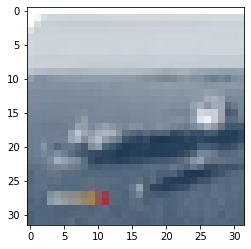

In [13]:
testindex = 4999
img = x_train[testindex]
#print("Correct label =",label_name(y_test_numerical[testindex]))
print(plt.imshow(img))
img = img.reshape((1,) + img.shape)

encoding = vae.encoder.predict(img)
reconst = vae.decoder.predict(encoding)[0].squeeze()

print(encoding)

#filepath = os.path.join(self.run_folder, 'images','img_' + str(self.epoch).zfill(3) + '_' + str(batch) + '.jpg')
#print("Prediction:",vae.encoder.predict(img))
#print("Prediction:",vae.decoder.predict(vae.encoder.predict(img)))
#print(vae.decoder.predict(vae.encoder.predict(img)).type
#print(vae.encoder.predict)
#plt.imshow(vae.decoder.predict(vae.encoder.predict(img)))

In [ ]:
print(plt.imshow(reconst))

In [ ]:
import matplotlib.pyplot as plt
testindex = 51
img = x_test[testindex]
plt.imshow(img)
print(label_name(y_test_numerical[testindex]))